In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [ ]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from anndata import AnnData
import skmisc
import regex as re
import scipy.stats as stats
from itertools import combinations
import celltypist
from celltypist import models

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp
import functions_plotting as dplt
import functions_for_CAR_annotation as ca
import functions_OVA_annotation as oa

/tmp/ipykernel_3997041/666125554.py:21: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
#if needed, reload functions
import importlib
importlib.reload(dp)
importlib.reload(dplt)
importlib.reload(ca)

<module 'functions_for_CAR_annotation' from '/home/s377963/car_t_sc/02_code/functions/functions_for_CAR_annotation.py'>

# 1. Workflow with the CARs annotated via bowtie2

In [63]:
#import data

# adata_raw = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_raw_demultiplexed.h5ad') 
adata_qc = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc.h5ad')
# adata_TIL_only = adata_qc[adata_qc.obs.Location != 'dLN']
adata_pureTC = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc_TIL_only_pure_TC_annotation.h5ad') 
# adata_only_pureTC = adata_pureTC[adata_pureTC.obs['is.pure_Tcell'] == 'Pure']
# adata_pure_TC_annotated = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc_TIL_only_pure_TC_annotation_non_TC_filtered_TC_subtypes_annotated.h5ad') 
# adata_only_annotatedTC = adata_pure_TC_annotated[~adata_pure_TC_annotated.obs['functional.cluster'].isna()]

In [64]:
non_annotated = [adata_qc, adata_pureTC]

In [65]:
for adata in non_annotated:
    adata.obs.rename(columns={"HTO_classification": "Classification"}, inplace=True) 
    adata.obs.rename(columns={"functional.cluster": "Tcell_subtype"}, inplace=True)
    adata.obs.rename(columns={"pool": "dataset"}, inplace=True)
    rmvd_p = [int(dataset.replace("P", "")) - 1 for dataset in adata.obs['dataset']]
    adata.obs['dataset'] = rmvd_p

In [66]:
#normalize as celltypist requires this
for adata in non_annotated:
    adata.layers['raw'] = adata.X
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

In [69]:
adata_pureTC.obsm['int_X_pca'] = adata_pureTC.obsm['X_pca']
del adata_pureTC.obsm['X_pca']
sc.pp.pca(adata_pureTC)
sc.pp.neighbors(adata_pureTC)
sc.tl.leiden(adata_pureTC, resolution=0.4, flavor="igraph", n_iterations=2)

sc.pp.pca(adata_qc)
sc.pp.neighbors(adata_qc)
sc.tl.umap(adata_qc)
sc.tl.leiden(adata_qc, resolution=0.4, flavor="igraph", n_iterations=2)

In [ ]:
#download celltypist models
models.download_models(force_update = True)
#select the immune model
model_low = models.Model.load(model = 'Immune_All_Low.pkl')
model_high = models.Model.load(model = 'Immune_All_High.pkl')

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /home/s377963/.celltypist/data/models
💾 Downloading model [1/54]: Immune_All_Low.pkl
💾 Downloading model [2/54]: Immune_All_High.pkl
💾 Downloading model [3/54]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/54]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/54]: Adult_Human_MTG.pkl
💾 Downloading model [6/54]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [7/54]: Adult_Human_PrefrontalCortex.pkl
💾 Downloading model [8/54]: Adult_Human_Skin.pkl
💾 Downloading model [9/54]: Adult_Human_Vascular.pkl
💾 Downloading model [10/54]: Adult_Mouse_Gut.pkl
💾 Downloading model [11/54]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [12/54]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [13/54]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [14/54]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [15/54]: COVID19_HumanChallenge_Blood

In [192]:
predictions_TC = celltypist.annotate(adata_pureTC, model = model_high, majority_voting = True, mode='prob match', p_thres=0.003)
# predictions_qc = celltypist.annotate(adata_qc, model = model_high, majority_voting = True)
# predictions = celltypist.annotate(adata_pureTC, model = model_low, majority_voting = True)

🔬 Input data has 16906 cells and 33696 genes
🔗 Matching reference genes in the model
🧬 6 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [194]:
celltypes_TC.obs.majority_voting

AAACCTGAGACAGGCT-1_1    B cells|T cells
AAACCTGCACAGGTTT-1_1    B cells|T cells
AAACCTGCATGAAGTA-1_1    B cells|T cells
AAACCTGGTAGGACAC-1_1    B cells|T cells
AAACCTGTCGCATGGC-1_1    B cells|T cells
                             ...       
TTTGGTTTCTCGATGA-1_9    B cells|T cells
TTTGTCACAGGCAGTA-1_9    B cells|T cells
TTTGTCAGTTCAGACT-1_9    B cells|T cells
TTTGTCATCCACGAAT-1_9    B cells|T cells
TTTGTCATCCGTAGTA-1_9    B cells|T cells
Name: majority_voting, Length: 16906, dtype: category
Categories (3, object): ['B cells|Double-positive thymocytes|Fibroblast..., 'B cells|Macrophages|T cells', 'B cells|T cells']

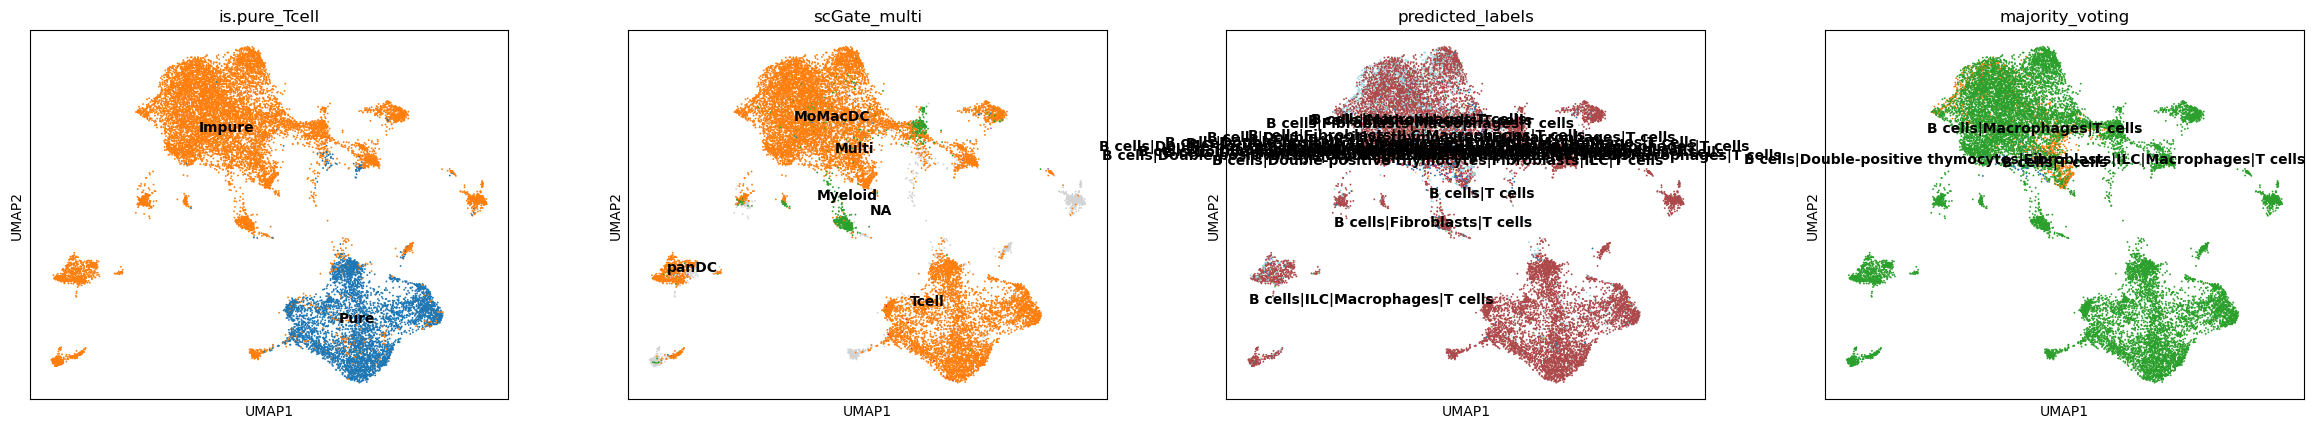

In [193]:
celltypes_TC = predictions_TC.to_adata()
# celltypes_qc = predictions_qc.to_adata()
sc.pl.umap(celltypes_TC, color = ['is.pure_Tcell', 'scGate_multi', 'predicted_labels', 'majority_voting'], legend_loc = 'on data')
# sc.pl.umap(celltypes_qc, color = ['predicted_labels', 'majority_voting'], legend_loc = 'on data')